# Tutorial - Run DE on simulated data

## Load libraries & Setup config

In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'svg' 

In [2]:
import os
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import delnx as dx
import matplotlib.pyplot as plt
from pathlib import Path

## Load data

In [3]:
# Parameters
cell_type = "Enterocytes"
condition = "FXR"

results_dir = Path("/projects/site/pred/ihb-intestine-evo/lukas_area/parse_nuclear_receptor_screen/tables")
processing_dir = Path("/projects/site/pred/ihb-intestine-evo/lukas_area/parse_nuclear_receptor_screen/processing")

# Load & Parse DE Results
def parse_de_results(path: Path) -> pd.DataFrame:
    """
    Parses a DE result CSV file and adds a 'cell_type' column inferred from the filename.
    """
    df = pd.read_csv(path)
    df.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)
    df["cell_type"] = path.stem.replace("de_condition_", "").replace("_results", "")
    return df

# Load and concatenate all DE results
all_results = pd.concat(
    map(parse_de_results, results_dir.glob("*.csv")),
    axis=0
)

# Flip DE direction (to control - condition)
all_results["coef"] = -all_results["coef"]
all_results["log2fc"] = -all_results["log2fc"]

# Filter for desired cell type and condition
de_results = all_results.query("cell_type == @cell_type and test_condition == @condition").copy()

In [4]:
dx.pp.label_de_genes(de_results)

/pstore/data/ihb-g-deco/USERS/adaml9/miniforge3/envs/delnx/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
de_results.head()

feature test_condition ref_condition     log2fc     auroc       coef  \
83980    ACSM3            FXR       control  -0.476417  0.502666  -4.780060   
83981   ZNF207            FXR       control  -0.001972  0.496919  -0.643090   
83982     FMO1            FXR       control  18.020361  0.498837  13.888906   
83983     MKS1            FXR       control  -0.155897  0.500827  -2.144379   
83984  CYP3A43            FXR       control  18.605322  0.499003  13.083153   

       pval  padj    cell_type  -log10(pval)  separation significant  
83980   0.0   0.0  Enterocytes          50.0    0.002666        Down  
83981   0.0   0.0  Enterocytes          50.0    0.003081          NS  
83982   0.0   0.0  Enterocytes          50.0    0.001163          Up  
83983   0.0   0.0  Enterocytes          50.0    0.000827        Down  
83984   0.0   0.0  Enterocytes          50.0    0.000997          Up

In [6]:
# Load adata
adata_path = processing_dir / "adata_contrastiveVI_annotated_log_norm_raw.h5ad"

adata = sc.read(adata_path)

# Filter for relevant cell types and conditions
adata_filtered = adata[
    adata.obs["cell_type"].isin(["Enterocytes", "Goblet cells"]) &
    adata.obs["condition"].isin(["control", "FXR", "AHR"])
].copy()

## Plot volcano plot

In [7]:
dx.pl.volcanoplot(de_results, label_top=5)

## Get top 20 differentially expressed genes

In [8]:
top_up, top_down = dx.pp.get_top_de_genes(de_results, top_n=200)
gene_set = top_down
len(gene_set)

200

## Plot heatmap of top 20 differentially expressed genes

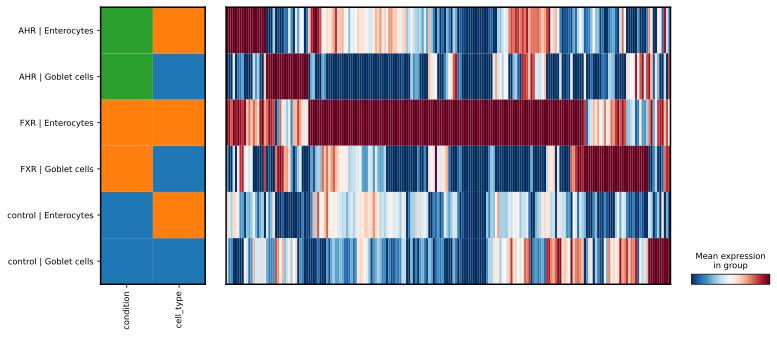

In [12]:
fig = dx.pl.matrixplot(
        adata_filtered,
        var_names=gene_set,
        groupby=["condition", "cell_type"],
        cmap="RdBu_r",
        standard_scale="var",
        vmin=0,
        vmax=1,
        figsize=(12,5),
        show_row_names=True,
        show_col_names=False,
        return_fig=True,  # required for testability
        show=False,       # prevent blocking
        dendrogram=False
    )
fig.show()

## Perform gene set enrichment analysis

In [11]:
enrichment_results = dx.tl.run_gsea(genes=gene_set)

In [12]:
enrichment_results.head()

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap   P-value  \
0   response to reactive oxygen species (GO:0000302)    2/59  0.006210   
1  beta-catenin destruction complex assembly (GO:...     1/5  0.009961   
2  response to denervation involved in regulation...     1/5  0.009961   
3  blood vessel endothelial cell proliferation in...     1/6  0.011942   
4  intermediate filament bundle assembly (GO:0045...     1/7  0.013918   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.201259            0                     0   18.377655   
1          0.201259            0                     0  127.923077   
2          0.201259            0                     0  127.923077   
3          0.201259            0                     0  102.333333   
4          0.201259            0                     0   85.273504   

   Combined Score        Genes  
0       93.389167  STK25;ROMO1  
1      589.607807        AMER1  
2      589.607807       FBXO32  
3      453.104671        NRARP  
4      364.506348         PKP1

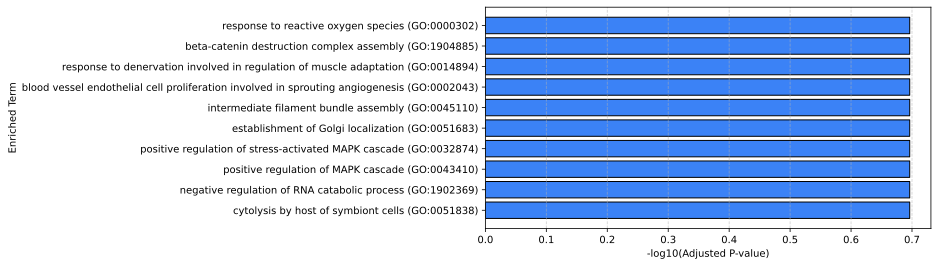

(<Figure size 800x400 with 1 Axes>,
 <Axes: xlabel='-log10(Adjusted P-value)', ylabel='Enriched Term'>)

In [13]:
dx.pl.plot_gsea(enrichment_results=enrichment_results)